Customer churn, the loss of subscribers, is a major concern for telecom companies. Retaining existing customers is often cheaper and more profitable than acquiring new ones. In this project, we will delve into the world of telecom customer churn by performing Exploratory Data Analysis (EDA) and building predictive models on a telecom customer churn dataset.

Our goals are to:
- Understand the dataset Through EDA
- Perform Pre-Processing, including transformation, feature selection, and balancing
- Performing Prediction and comparing results on base(not tuned) models.

# Importing libraries


In [5]:
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, precision_score, f1_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings('ignore')

path = "./WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [6]:
# Draw Confusion Matrix
def draw_cf(y_test, predict_y):
    plt.figure(figsize=(4,3))
    cf_matrix = confusion_matrix(y_test, predict_y)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    plt.title("Confusion Matrix")
    plt.show()
# Draw ROC Curve
def draw_rc(model, X_test):
    y_ab_prob = model.predict_proba(X_test)[:,1]
    fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_ab_prob)
    plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve',fontsize=16)
    plt.show();

# Initial Data  Exoloration

In [ ]:
# Read data
df = pd.read_csv(path)

In [ ]:
# Sample data
display(pd.concat([df.head(), df.sample(n=5), df.tail()]))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
4348,6121-VZNQB,Female,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,19.10,19.1,Yes
4770,7762-ONLJY,Female,0,Yes,Yes,6,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.70,94.45,No
5420,7929-SKFGK,Male,0,Yes,No,70,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),114.30,8244.3,No
501,4513-CXYIX,Female,1,Yes,No,71,Yes,Yes,Fiber optic,Yes,...,No,No,No,No,Two year,Yes,Credit card (automatic),80.70,5676,No
4948,3446-QDSZF,Female,0,No,No,4,Yes,No,DSL,No,...,No,No,Yes,No,Month-to-month,No,Credit card (automatic),55.50,227.35,No


In [ ]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Unique values in each column
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

# Extract, Transform, and Load (ETL)

▶ Note that how we are dealling with missing values depends on the algorithms and test results. Here I'm filling them with zero, but might test other changes such as mean value.

In [7]:
# Read data
df = pd.read_csv(path)
# This column is not needed. we use dataframe's own index
df = df.drop(['customerID'], axis = 1)
# Most columns use Yes/No values, except this column. it's fixed
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
# Some values are missing, so it's filled with zero
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Exploratory Data Analysis

## Sampling and Data Dictionary

In [8]:
# Sample data
display(pd.concat([df.head(), df.sample(n=5), df.tail()]))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
4786,Male,No,No,No,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Electronic check,103.65,7634.80,No
1524,Female,No,No,No,63,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),109.85,7002.95,No
3840,Male,Yes,Yes,No,64,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),25.65,1740.80,No
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
2430,Male,No,No,No,30,Yes,No,DSL,Yes,No,Yes,No,No,No,Two year,Yes,Mailed check,55.65,1653.85,No


In [9]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


## Data Visualization

In [10]:
# Define subplot titles and data columns
data_cols = ["gender", "SeniorCitizen", "Partner", "Dependents"]
titles = ["Gender", "Senior Citizen", "Partner", "Dependents"]

fig = go.FigureWidget(make_subplots(rows=2, cols=4, specs=[
                                                        [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
                                                        [{'type':'xy'}, {'type':'xy'}, {'type':'xy'}, {'type':'xy'}]]))

row, col = 1, 0
for i, (title, data_col) in enumerate(zip(titles, data_cols)):
    col=col+1
    # Get value counts for pie chart
    value_counts = df[data_col].value_counts()

    # Create pie charts
    pie_chart = go.Pie(labels=value_counts.index, values=value_counts.to_numpy(), name=title, title=title)
    fig.add_trace(pie_chart, row=row, col=col)

row, col = 2, 0
for i, (title, data_col) in enumerate(zip(titles, data_cols)):
    col=col+1
    # get churn rates
    churn_counts = df.groupby([data_col, 'Churn'])['Churn'].count().unstack()

    # Create stacked bar charts
    t1 = go.Bar(name='Churn (yes)', x=churn_counts['Yes'].index, y=churn_counts['Yes'])
    t2 = go.Bar(name='Churn (no)', x=churn_counts['No'].index, y=churn_counts['No'], marker_color='indianred')
    fig.add_trace(t1, row=row, col=col)
    fig.add_trace(t2, row=row, col=col)
    fig.update_layout(barmode='stack')

fig.update_layout(title="Distribution of Customer Details", showlegend=False)
fig.show()


In [29]:

# Define subplot titles and data columns
data_cols = ['PhoneService' ,'MultipleLines' ,'InternetService' ,'OnlineBackup' ,'DeviceProtection' ,'TechSupport' ,'StreamingTV' ,'StreamingMovies']
titles = ['Phone Service' ,'Multiple Lines' ,'Internet Service' ,'Online Backup' ,'Device Protection' ,'Tech Support' ,'Streaming TV' ,'Streaming Movies']

hor_space = 0.02
ver_space = 0.02

fig = go.FigureWidget(make_subplots(rows=4,
                                    cols=4,
                                    specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
                                           [{'type':'xy'}, {'type':'xy'}, {'type':'xy'}, {'type':'xy'}],
                                           [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
                                           [{'type':'xy'}, {'type':'xy'}, {'type':'xy'}, {'type':'xy'}]
                                           ],
                                    horizontal_spacing=hor_space, # in range 0 to 1/(cols-1)
                                    vertical_spacing=ver_space # in range 0 to 1/(rows-1)
                                    )
                      )

row, col = 1, 0
for i, (title, data_col) in enumerate(zip(titles, data_cols)):
    row, col = divmod(i, 4)
    row = row * 2

    # Get value counts for pie chart
    value_counts = df[data_col].value_counts()
    # Create pie chart trace and add to subplot
    pie_chart = go.Pie(labels=value_counts.index, values=value_counts.to_numpy(), name=title, title=title)
    fig.add_trace(pie_chart, row=row+1, col=col+1)

    # get churn rates
    churn_counts = df.groupby([data_col, 'Churn'])['Churn'].count().unstack()
    # Create stacked bar charts
    t1 = go.Bar(name='Churn (yes)', x=churn_counts['Yes'].index, y=churn_counts['Yes'])
    t2 = go.Bar(name='Churn (no)', x=churn_counts['No'].index, y=churn_counts['No'], marker_color='indianred')
    fig.add_trace(t1, row=row+2, col=col+1)
    fig.add_trace(t2, row=row+2, col=col+1)


fig.update_layout(title="Distribution of Customer Services",
                  barmode='stack',
                  showlegend=False,
                   margin={"l":0,
                           "r":0,
                           "t":25,
                           "b":25}
                  )
fig.show()

In [12]:
# Define subplot titles and data columns
titles = ['Contract' ,'Paperless Billing' ,'Payment Method']
data_cols = ['Contract' ,'PaperlessBilling' ,'PaymentMethod']

fig = go.FigureWidget(make_subplots(rows=2, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
                                                          [{'type':'xy'}, {'type':'xy'}, {'type':'xy'},]]))


row, col = 1, 0
for i, (title, data_col) in enumerate(zip(titles, data_cols)):
    col=col+1
    # Get value counts for pie chart
    value_counts = df[data_col].value_counts()

    # Create pie chart trace and add to subplot
    pie_chart = go.Pie(labels=value_counts.index, values=value_counts.to_numpy(), name=title, title=title)
    fig.add_trace(pie_chart, row=row, col=col)

row, col = 2, 0
for i, (title, data_col) in enumerate(zip(titles, data_cols)):
    col=col+1
    # get churn rates
    churn_counts = df.groupby([data_col, 'Churn'])['Churn'].count().unstack()

    # Create stacked bar charts
    t1 = go.Bar(name='Churn (yes)', x=churn_counts['Yes'].index, y=churn_counts['Yes'])
    t2 = go.Bar(name='Churn (no)', x=churn_counts['No'].index, y=churn_counts['No'], marker_color='indianred')
    fig.add_trace(t1, row=row, col=col)
    fig.add_trace(t2, row=row, col=col)
    fig.update_layout(barmode='stack')

fig.update_layout(title="Distribution of Contract, Billing, and Payment Methods", showlegend=False)
fig.show()


In [13]:
fig = px.histogram(data_frame=df, x=df['tenure'], color='Churn', title="Distribution of Number of users per tenure", histnorm=None, text_auto=True)
fig.show()

# 1. Visualize distribution of Monthly Charges
fig_monthly_charges = px.histogram(data_frame=df, x=df['MonthlyCharges'], color='Churn', title="Distribution of Monthly Charges", histnorm=None, text_auto=True)
fig_monthly_charges.show()


In [14]:
data_cols = ['MonthlyCharges', 'TotalCharges']
df_vis = df[data_cols].sort_values(by='TotalCharges')

fig = go.Figure(go.Scatter(
    x=df_vis['MonthlyCharges'],
    y=df_vis['TotalCharges'],
    mode='markers',
    marker=dict(
        size=10,
        color='royalblue'
    )
))

fig.update_layout(
    title='Monthly Charges vs. Total Charges Distribution',
    xaxis_title='Monthly Charges',
    yaxis_title='Total Charges'
)
fig.show()


In [15]:
df_vis = df[['MonthlyCharges', 'tenure', 'Churn']].sort_values(by='tenure')
fig = px.histogram(df_vis, x="tenure", y="MonthlyCharges", color="Churn",
                   marginal="violin", barmode="overlay",
                   hover_data=df_vis.columns)
fig.show()

df_vis = df[['TotalCharges', 'tenure', 'Churn']].sort_values(by='tenure')
fig = px.histogram(df_vis, x="tenure", y="TotalCharges", color="Churn",
                   marginal="violin", barmode="overlay",
                   hover_data=df_vis.columns)
fig.show()

In [16]:
fig = px.density_contour(df, x='TotalCharges')  # 'TotalCharges' column for density

fig.update_layout(
    title='Density Distribution of Total Charges',
    xaxis_title='Total Charges',
    yaxis_title='Density'
)

fig.show()

Here we calculate the correlation coefficients between the columns of our DataFrame. It creates this Correlation Matrix which is a table where each cell represents the correlation coefficient between a pair of columns in the DataFrame.

It helps us understand the relationship between features and helps with Feature Selection.

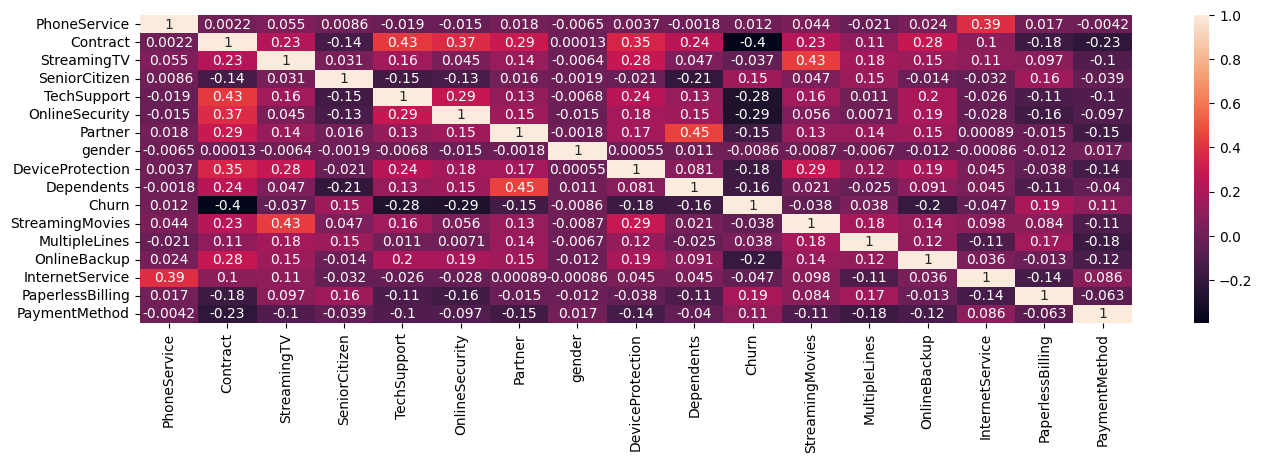

In [17]:
all_columns = list(df)
num_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_columns = list(set(all_columns) - set(num_columns))
df_categorical_transformed = df[cat_columns].apply(lambda x: LabelEncoder().fit_transform(x) if x.dtype == 'object' else x)


plt.figure(figsize = (16, 4))
sns.heatmap(df_categorical_transformed.corr(), cmap=sns.color_palette("rocket", as_cmap=True), annot=True);

# Data Pre-Processing

## Transformations and feature selection

In [ ]:
all_columns = list(df)
num_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_columns = list(set(all_columns) - set(num_columns))

# Transform all categorical values into encoded nummerical labeles
df[cat_columns] = df[cat_columns].apply(lambda x: LabelEncoder().fit_transform(x) if x.dtype == 'object' else x)

# Transform all numerical values into a min max Normalization
# Standardizationcan be tested too: ss = StandardScaler()
mms = MinMaxScaler() # Normalization
df[num_columns] = pd.DataFrame(mms.fit_transform(df[num_columns]), columns=num_columns)

display(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,0.013889,0,1,0,0,2,0,0,0,0,0,1,2,0.115423,0.003437,0
1,1,0,0,0,0.472222,1,0,0,2,0,2,0,0,0,1,0,3,0.385075,0.217564,0
2,1,0,0,0,0.027778,1,0,0,2,2,0,0,0,0,0,1,3,0.354229,0.012453,1
3,1,0,0,0,0.625000,0,1,0,2,0,2,2,0,0,1,0,0,0.239303,0.211951,0
4,0,0,0,0,0.027778,1,0,1,0,0,0,0,0,0,0,1,2,0.521891,0.017462,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,0.333333,1,2,0,2,0,2,2,2,2,1,1,3,0.662189,0.229194,0
7039,0,0,1,1,1.000000,1,2,1,0,2,2,0,2,2,1,1,1,0.845274,0.847792,0
7040,0,0,1,1,0.152778,0,1,0,2,0,0,0,0,0,0,1,2,0.112935,0.039892,0
7041,1,1,1,0,0.055556,1,2,1,0,0,0,0,0,0,0,1,3,0.558706,0.035303,1


## Feature Selection

### Correlation Coefficient
Here we calculates the correlation coefficients to discover linear relationship between the Churn column and other features.

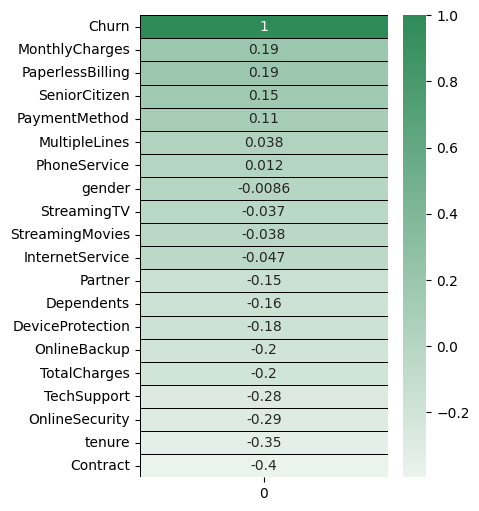

In [ ]:
corr = df.corrwith(df['Churn']).sort_values(ascending=False).to_frame()
plt.subplots(figsize=(4,6))
sns.heatmap(corr,annot = True, cmap=sns.light_palette("seagreen", as_cmap=True), linewidths=0.4, linecolor='black');

### Chi-Squared Test
Here we use Chi-Squared Test which can be used the relationship between categorical variabls.

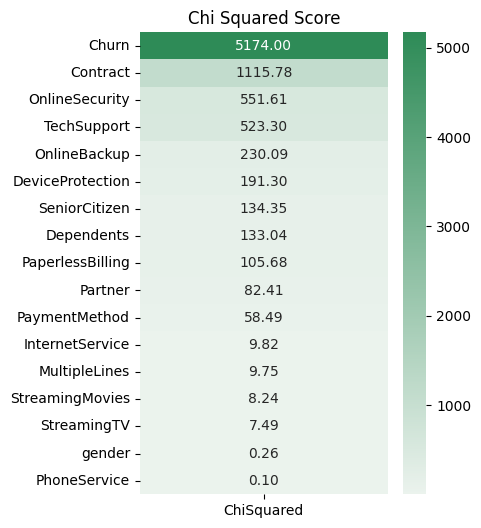

In [ ]:
features = df.loc[:,cat_columns]
target = df.loc[:,'Churn']
best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)
feature_scores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ChiSquared'])

plt.subplots(figsize = (4,6))
sns.heatmap(feature_scores.sort_values(ascending=False, by='ChiSquared'), cmap=sns.light_palette("seagreen", as_cmap=True), annot=True, fmt='.2f');
plt.title('Chi Squared Score');

### ANOVA Test
ANOVA (Analysis of Variance) helps identify features that have a statistically significant impact on the nummerical target features. ANOVA can help in correlation analysis and discovering feature importance scores.

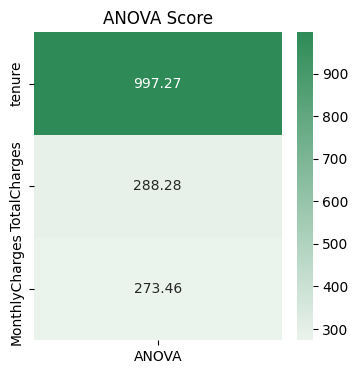

In [ ]:
features = df.loc[:, num_columns]
target = df.loc[:, 'Churn']
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)
feature_scores = pd.DataFrame(data = fit.scores_,index = list(features.columns), columns = ['ANOVA'])

plt.subplots(figsize = (4,4))
sns.heatmap(feature_scores.sort_values(ascending=False, by='ANOVA'), annot=True, cmap=sns.light_palette("seagreen", as_cmap=True),fmt = '.2f');
plt.title('ANOVA Score');

## Balancing Data
SMOTE (Synthetic Minority Oversampling Technique) is used to synthesizes new examples for the minority classes. It helps the classifier to build larger decision regions for minority classes. We are also first using unnder-sampling to trim the majority class, then use SMOTE to oversample the minority class.

> The combination of SMOTE and under-sampling performs better than plain under-sampling.
>
> [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813), 2011

Following code offers three choices. SMOTE, SMOTEENN, and no Balancing option.


In [ ]:
# @title Data Balancing Choice
balancing_choice = "SMOTE" # @param ["SMOTE", "SMOTEENN", "No Balancing"]
def sample_counter(data_series):
    print(data_series)
    counter = Counter(data_series)
    for label, value in counter.items():
        per = value / len(data_series) * 100
        print('Class=%s, Count=%d, Percentage=%.2f%%' % (label, value, per))

def balance_data(balancing_choice="No Balancing"):
    # No balancing
    X = df.drop(columns = ['Churn'])
    y = df['Churn'].values
    # SMOTEENN
    if balancing_choice == "SMOTEENN":
        oversample = SMOTEENN()
        X, y = oversample.fit_resample(X, y)
    # SMOTE
    elif balancing_choice == "SMOTE":
        oversample = SMOTE(sampling_strategy='auto')
        X, y = oversample.fit_resample(X, y)
    return (X,y)

print(f"Before Resampling:")
X,y = balance_data()
sample_counter(y)

print(f"After Resampling:")
X,y = balance_data(balancing_choice)
sample_counter(y)

Before Resampling:
[0 0 1 ... 0 1 0]
Class=0, Count=5174, Percentage=73.46%
Class=1, Count=1869, Percentage=26.54%
After Resampling:
[0 0 1 ... 1 1 1]
Class=0, Count=5174, Percentage=50.00%
Class=1, Count=5174, Percentage=50.00%


## Spliting training and testing data

In [ ]:
# Spliting data for machine learning training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 100, stratify=y)

# Prediction

## Classification using KNN
KNN (K-Nearest Neighbors) is a supervised machine learning algorithm used for both classification and regression tasks. KNN can be a good choice for churn prediction, especially in situations where dataset is not very large or interpretibilty is important.

ℹ Note that balancing method can change the optimal n_neighbors value.

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train,y_train)
predict_y = knn_model.predict(X_test)
knn_accuracy = knn_model.score(X_test, y_test)

print(f"Accuracy: {knn_accuracy}")
print(classification_report(y_test, predict_y))

Accuracy: 0.7723027375201288
              precision    recall  f1-score   support

           0       0.82      0.70      0.75      1553
           1       0.74      0.85      0.79      1552

    accuracy                           0.77      3105
   macro avg       0.78      0.77      0.77      3105
weighted avg       0.78      0.77      0.77      3105



The value for K, which represents the number of nearest neighbors to consider during classification and can significantly impact performance. Experimentation and validation are crucial to find the best K. Here I use Grid Search.
▶ Note that before and after Balancing Data(resampling) you might get different results. It's always better to calculate your clusters before balancing data.

In [ ]:
param_grid = {'n_neighbors': list(range(1, 21))}

knn_model = KNeighborsClassifier()
# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_model, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X, y)
best_k = grid_search.best_params_['n_neighbors']

print(f"Best K value found through grid search: {best_k}")

Best K value found through grid search: 3


## SVC
Support Vector Classifier(SVC) is a supervised machine learning algorithm widely used for classification tasks. SVC can be a good choice for churn prediction because it excels at finding clear separation between classes (churning vs. non-churning customers).

▶ SVC may be effective even with imbalanced datasets, where churners are often a smaller proportion of the customer base.

In [ ]:
svc_model = SVC(random_state=1)
svc_model.fit(X_train,y_train)
predict_y = svc_model.predict(X_test)
svc_accuracy = svc_model.score(X_test, y_test)

print(f"Accuracy: {svc_accuracy}")
print(classification_report(y_test, predict_y))

Accuracy: 0.7819645732689211
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1553
           1       0.76      0.83      0.79      1552

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105



## Decision Tree Classifier
A Decision Tree Classifier is a supervised learning algorithm used for classification tasks. It works by building a tree-like model that splits the data based on features (attributes) to predict a target variable (class label).

Since we've already performed Feature Scaling and varied data types are already encoded, DTC doen't provide any advantage compared to other algorithms aside from it's simplicity and interpretability.

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
predictdt_y = dt_model.predict(X_test)
dt_accuracy = dt_model.score(X_test,y_test)

print(f"Accuracy: {dt_accuracy}")
print(classification_report(y_test, predict_y))

Accuracy: 0.74170692431562
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1553
           1       0.76      0.83      0.79      1552

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105



## Random Forest

In [ ]:
model_rf = RandomForestClassifier(
      random_state=1,
      n_estimators=100,
      n_jobs=-1, # all processors
      max_features="sqrt",
      max_leaf_nodes=50)
model_rf.fit(X_train, y_train)

predict_y = model_rf.predict(X_test)
rf_accuracy = model_rf.score(X_test, y_test)

print(f"Accuracy: {rf_accuracy}")
print(classification_report(y_test, predict_y))

Accuracy: 0.7864734299516908
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1553
           1       0.76      0.83      0.80      1552

    accuracy                           0.79      3105
   macro avg       0.79      0.79      0.79      3105
weighted avg       0.79      0.79      0.79      3105



The confusion matrix is a valuable tool for understanding how well your Random Forest model performs in classifying data. By analyzing the distribution of values within the matrix, you can gain valuable insights into the model's strengths and weaknesses, allowing for targeted improvements and better decision-making.

Each cell in the table contains the number of data points that fall into a specific combination of actual and predicted classes:
- True Positives (TP): These are data points where the model correctly - predicted the positive class.
- True Negatives (TN): These are data points where the model correctly - predicted the negative class.
- False Positives (FP): These are data points where the model incorrectly - predicted the positive class (Type I Error).
- False Negatives (FN): These are data points where the model incorrectly predicted the negative class (Type II Error).

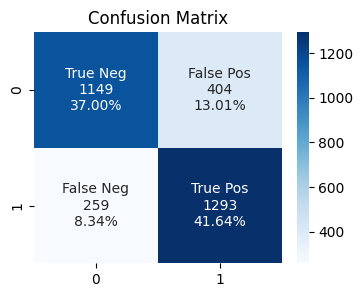

In [ ]:
draw_cf(y_test, predict_y)

The Receiver Operating Characteristic (ROC) Curve is a valuable tool for evaluating the performance of Random Forest models in classification tasks. By understanding the trade-off between TPR and FPR, you can make informed decisions about threshold selection and model optimization.

By analyzing the curve, you can select an appropriate classification threshold based on your specific needs. For example, if minimizing false positives is more crucial (e.g., spam detection), you might choose a threshold with a lower FPR.

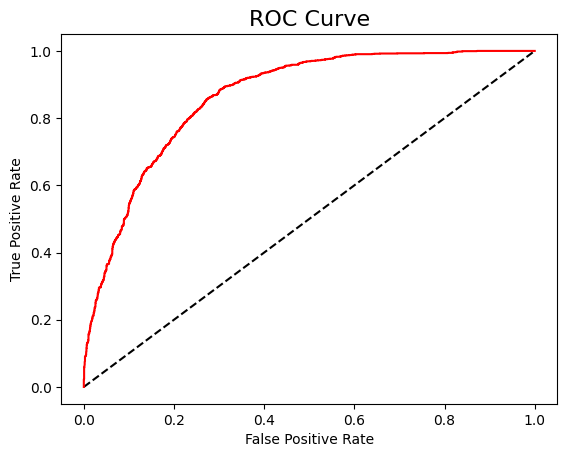

In [ ]:
draw_rc(model_rf, X_test)

The Area Under the ROC Curve (AUC) is a single metric summarizing the overall performance of the model. A higher AUC indicates better classification performance.

## AdaBoost Classifier
AdaBoost (Adaptive Boosting) is an ensemble machine learning algorithm used for classification tasks. It works by combining multiple weak learners (typically decision trees) into a single strong learner.

AdaBoost can be a good choice for churn prediction due to its strengths:

- Effective with Complex Relationships: Churn often depends on a complex interplay between various factors. AdaBoost's ability to combine multiple weak learners can be beneficial in capturing these complex relationships.
- Robust to Imbalanced Classes: Churn data might be imbalanced, with a smaller number of churned customers compared to non-churned ones. AdaBoost's focus on misclassified points can help address this imbalance.


In [ ]:
ab_model = AdaBoostClassifier()
ab_model.fit(X_train,y_train)
predict_y = ab_model.predict(X_test)
ab_accuracy = ab_model.score(X_test, y_test)

print(f"Accuracy: {ab_accuracy}")
print(classification_report(y_test, predict_y))

Accuracy: 0.7861513687600644
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1553
           1       0.76      0.84      0.80      1552

    accuracy                           0.79      3105
   macro avg       0.79      0.79      0.79      3105
weighted avg       0.79      0.79      0.79      3105



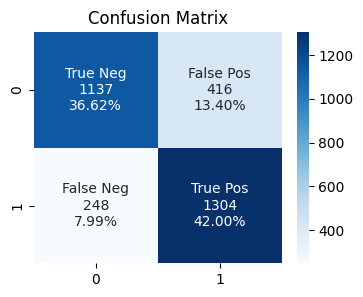

In [ ]:
draw_cf(y_test, predict_y)

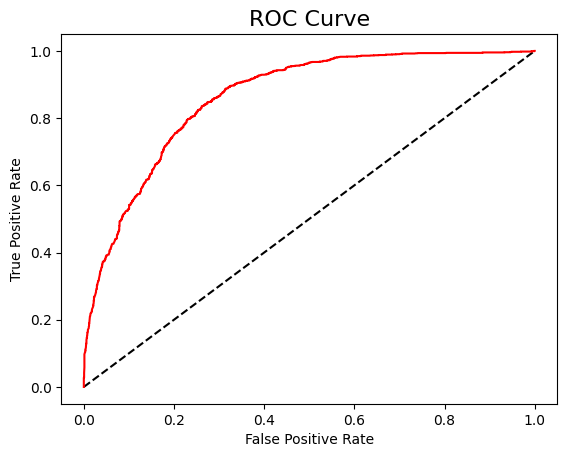

In [ ]:
draw_rc(ab_model, X_test)

## Gradient Boosting Classifier
Gradient Boosting Classifier (GBC) is a powerful ensemble machine learning algorithm well-suited for churn prediction tasks. Because compared to similar algorithms it's effective at Feature Learning and highly Interpretabile, even if it require a lot of parameter tuning and more computational resources.

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
predict_y = gb.predict(X_test)
gb_accuracy = ab_model.score(X_test, y_test)

print(f"Accuracy: {gb_accuracy}")
print(classification_report(y_test, predict_y))

Accuracy: 0.7861513687600644
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1553
           1       0.77      0.85      0.81      1552

    accuracy                           0.80      3105
   macro avg       0.80      0.80      0.80      3105
weighted avg       0.80      0.80      0.80      3105



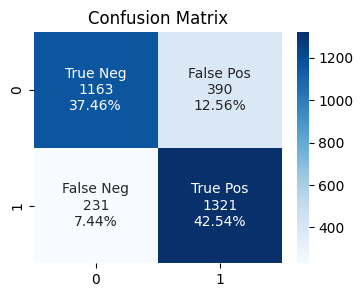

In [ ]:
draw_cf(y_test, predict_y)

## LightGBM Classifier

In [ ]:
lgb_model = LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, verbose=-1)
lgb_model.fit(X_train, y_train)
predict_y = lgb_model.predict(X_test)
gb_accuracy = lgb_model.score(X_test, y_test)

print(f"Accuracy: {gb_accuracy}")
print(classification_report(y_test, predict_y))

Accuracy: 0.7848631239935587
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1553
           1       0.75      0.85      0.80      1552

    accuracy                           0.78      3105
   macro avg       0.79      0.78      0.78      3105
weighted avg       0.79      0.78      0.78      3105



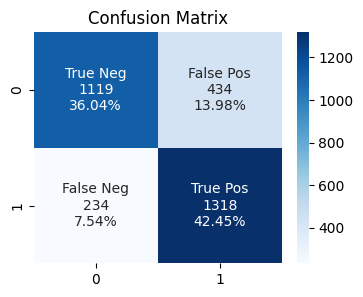

In [ ]:
draw_cf(y_test, predict_y)

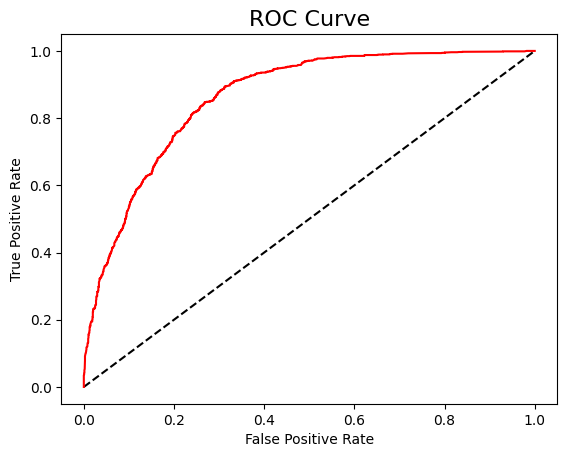

In [ ]:
draw_rc(lgb_model, X_test)

## Xgboost Classifier

In [ ]:
xgb_model = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000)
xgb_model.fit(X_train, y_train)
predict_y = xgb_model.predict(X_test)
gb_accuracy = xgb_model.score(X_test, y_test)

print(f"Accuracy: {gb_accuracy}")
print(classification_report(y_test, predict_y))

Accuracy: 0.794524959742351
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1553
           1       0.76      0.85      0.81      1552

    accuracy                           0.79      3105
   macro avg       0.80      0.79      0.79      3105
weighted avg       0.80      0.79      0.79      3105



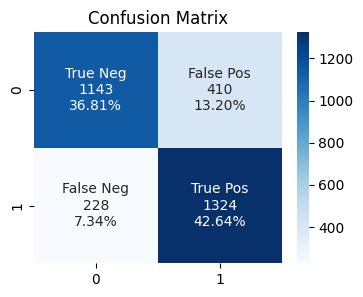

In [ ]:
draw_cf(y_test, predict_y)

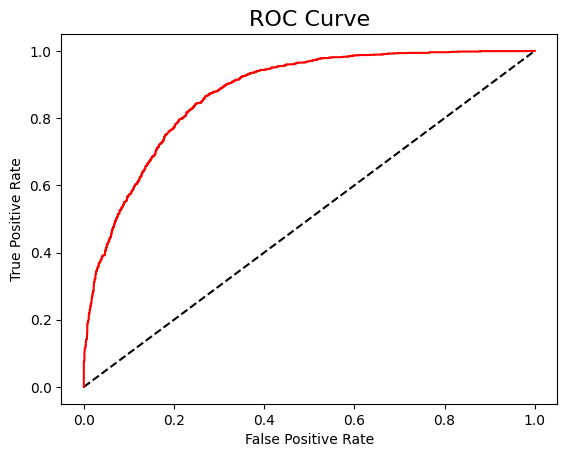

In [ ]:
draw_rc(xgb_model, X_test)

## Stacking and Voting Ensemble

In [ ]:
base_models = [
      ('LogReg', LogisticRegression()),
      ('GBoost', GradientBoostingClassifier()),
      ('AdaBoost', AdaBoostClassifier()),
      ('LGBoost', LGBMClassifier(verbose=-1)),
      ('XGBoost', XGBClassifier())]

all_models = base_models + [('stacking', StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5))]
all_models += [('voting', VotingClassifier(estimators=base_models, voting='soft'))]

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


### Voting Classifier
VotingClassifier in scikit-learn is an ensemble learning method that combines the predictions of several base models to produce a final, more robust prediction. Here we're going to use the last three ensemble model algorithms to train find the best model.

In [ ]:
vc_model = VotingClassifier(estimators=base_models, voting='soft')
vc_model.fit(X_train, y_train)
predict_y = vc_model.predict(X_test)
vc_accuracy = accuracy_score(y_test, predict_y)

display(vc_model)
print(f"Accuracy: {vc_accuracy}")
print(classification_report(y_test, predict_y))

VotingClassifier(estimators=[('LogReg', LogisticRegression()),
                             ('GBoost', GradientBoostingClassifier()),
                             ('AdaBoost', AdaBoostClassifier()),
                             ('LGBoost', LGBMClassifier(verbose=-1)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            e...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

Accuracy: 0.8154589371980676
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1553
           1       0.79      0.86      0.82      1552

    accuracy                           0.82      3105
   macro avg       0.82      0.82      0.82      3105
weighted avg       0.82      0.82      0.82      3105



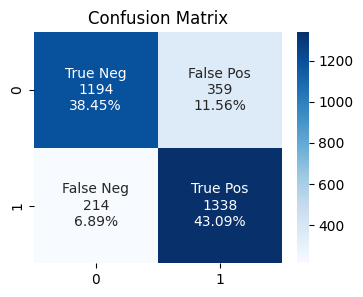

In [ ]:
draw_cf(y_test, predict_y)

### Stacking Classifier

In [ ]:
stack = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
vc_model.fit(X_train, y_train)
predict_y = vc_model.predict(X_test)
vc_accuracy = accuracy_score(y_test, predict_y)

display(vc_model)
print(f"Accuracy: {vc_accuracy}")
print(classification_report(y_test, predict_y))

VotingClassifier(estimators=[('LogReg', LogisticRegression()),
                             ('GBoost', GradientBoostingClassifier()),
                             ('AdaBoost', AdaBoostClassifier()),
                             ('LGBoost', LGBMClassifier(verbose=-1)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            e...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

Accuracy: 0.8154589371980676
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1553
           1       0.79      0.86      0.82      1552

    accuracy                           0.82      3105
   macro avg       0.82      0.82      0.82      3105
weighted avg       0.82      0.82      0.82      3105



## Comparing Models

LogReg Model:	mean=0.781	std=0.012
GBoost Model:	mean=0.806	std=0.011
AdaBoost Model:	mean=0.791	std=0.010
LGBoost Model:	mean=0.827	std=0.011
XGBoost Model:	mean=0.826	std=0.012
stacking Model:	mean=0.831	std=0.011
voting Model:	mean=0.823	std=0.010


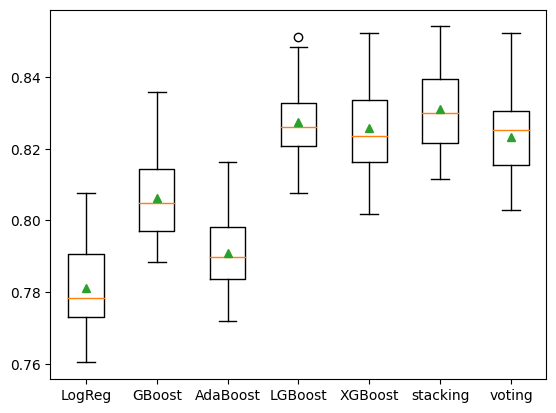

In [ ]:
# evaluate the models and store results
results, names = list(), list()
for item in all_models:
    name, model = item
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('%s Model:\tmean=%.3f\tstd=%.3f' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()